In [1]:
from fforma import *
import pandas as pd
from fforma.train_models import trainBasicModels
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_data(data = 'M4', freq = 'Monthly', frcy=12, val_periods=18, basic_models = [Naive(), SeasonalNaive(), RandomWalkDrift(), ETS()]):
    # Reding complete data
    if data == 'M4':
        data = pd.read_csv(f'data/data_m4/{freq}-train.csv')
        data_test = pd.read_csv(f'data/data_m4/{freq}-test.csv')

        # Train and test set
        ts_list_train = [ts[1:].dropna().values for idx, ts in data.iterrows()]
        ts_list_test = [ts[1:].dropna().values for idx, ts in data_test.iterrows()]
        random.seed(2020202)
        indexes = random.sample(range(len(ts_list_train)), k=2000)
        
        ts_list_train = [ts_list_train[idx] for idx in indexes]
        ts_list_test = [ts_list_test[idx] for idx in indexes]
    else:
        #freq_dict = {
        #    'Monthly': 'M'
        #}
        
        #freq_m3 = freq_dict[freq]
        data = pd.read_csv('data/data_cpi/cpi-ocde-val.csv')
        data_test = data.query('type=="test"')
        data = data.query('type=="train"')

        # Train and test set
        ts_list_train = [df['value'].values for idx, df in data.groupby('location')]
        ts_list_test = [df['value'].values for idx, df in data_test.groupby('location')]
        
    #Test periods
    test_periods = len(ts_list_test[0])
    
    # Validation set
    ts_train_for_val = [ts[:-val_periods] for ts in ts_list_train] 
    ts_val_list = [ts[-val_periods:] for ts in ts_list_train]
    
    # Prediction for validation set and train set
    ts_hat_val_list = trainBasicModels().train(basic_models, ts_train_for_val, frcy).predict(val_periods)
    ts_hat_list = trainBasicModels().train(basic_models, ts_list_train, frcy).predict(test_periods)
    
    
    data_dict = {
        'ts': ts_list_train, 'ts_test': ts_list_test, 'ts_hat_test': ts_hat_list,
        'ts_val': ts_val_list, 'ts_hat_val': ts_hat_val_list
    }
    
    return data_dict

In [3]:
frcy = 12

In [4]:
data_m4 = get_data(data='M4', val_periods=24)

100%|██████████| 2000/2000 [00:04<00:00, 479.40it/s]


In [6]:
data_cpi = get_data(data='CPI', val_periods=24) 

100%|██████████| 49/49 [00:00<00:00, 319.56it/s]


In [7]:
data_cpi_m4 = {}
for key in data_m4.keys():
    data_cpi_m4[key] = data_m4[key] + data_cpi[key]

In [8]:
fforma_complete_data = FForma(
    data_cpi_m4['ts'],
    data_cpi_m4['ts_val'],
    data_cpi_m4['ts_hat_val'],
    data_cpi_m4['ts_hat_test'],
    frcy,
    max_evals=10
).train()

  3%|▎         | 52/2049 [00:00<00:03, 514.06it/s]

Setting model
Computing contribution to owa
Training NAIVE2


100%|██████████| 2049/2049 [00:04<00:00, 478.69it/s]
2049it [00:00, 11085.95it/s]
0it [00:00, ?it/s]

Calculating errors


2049it [00:00, 3961.80it/s]
2049it [00:00, 44989.08it/s]
2049it [00:00, 14852.93it/s]


Naive 2 errors
Computing features
100%|██████████| 10/10 [02:05<00:00, 14.81s/it, best loss: 517.4367321234524]


In [9]:
fforma_cpi_data = FForma(
    data_cpi['ts'],
    data_cpi['ts_val'],
    data_cpi['ts_hat_val'],
    data_cpi['ts_hat_test'],
    frcy,
    max_evals=10
).train()

 16%|█▋        | 8/49 [00:00<00:00, 79.82it/s]

Setting model
Computing contribution to owa
Training NAIVE2


100%|██████████| 49/49 [00:00<00:00, 90.52it/s]
49it [00:00, 13021.66it/s]
49it [00:00, 5088.91it/s]
49it [00:00, 59040.76it/s]
49it [00:00, 10219.33it/s]


Calculating errors
Naive 2 errors
Computing features
100%|██████████| 10/10 [00:09<00:00,  1.03it/s, best loss: 12.431793115783888]


In [10]:
preds_complete_data = fforma_complete_data.predict(data_cpi['ts'], data_cpi['ts_hat_test'], frcy=frcy)
preds_complete_data = [[pred] for pred in preds_complete_data]

In [11]:
preds_cpi_data = fforma_cpi_data.predict(data_cpi['ts'], data_cpi['ts_hat_test'], frcy=frcy)
preds_cpi_data = [[pred] for pred in preds_cpi_data]

In [67]:
owa_complete_data = fforma_complete_data.contribution_to_owa(data_cpi['ts'], data_cpi['ts_test'], preds_complete_data, frcy=frcy).mean()
owa_complete_data


 16%|█▋        | 8/49 [00:00<00:00, 74.85it/s]

Training NAIVE2



100%|██████████| 49/49 [00:00<00:00, 99.36it/s]
0it [00:00, ?it/s]
49it [00:00, 13540.71it/s]
0it [00:00, ?it/s]
49it [00:00, 13160.08it/s]
0it [00:00, ?it/s]
49it [00:00, 27939.22it/s]
0it [00:00, ?it/s]
49it [00:00, 17500.08it/s]

Calculating errors
Naive 2 errors


0.9240208491231967

In [68]:
owa_cpi_data = fforma_cpi_data.contribution_to_owa(data_cpi['ts'], data_cpi['ts_test'], preds_cpi_data, frcy=frcy).mean()
owa_cpi_data


 22%|██▏       | 11/49 [00:00<00:00, 108.87it/s]

Training NAIVE2



100%|██████████| 49/49 [00:00<00:00, 112.04it/s]
0it [00:00, ?it/s]
49it [00:00, 33089.82it/s]
0it [00:00, ?it/s]
49it [00:00, 14045.99it/s]
0it [00:00, ?it/s]
49it [00:00, 39837.35it/s]
0it [00:00, ?it/s]
49it [00:00, 9687.53it/s]

Calculating errors
Naive 2 errors


0.9207525618549862

In [17]:
ecm = [np.sqrt((test-actual)**2).mean() for test, actual in zip(data_cpi['ts_test'], preds_complete_data)]

In [19]:
data = pd.read_csv('data/data_cpi/cpi-ocde-val.csv')

In [21]:
data = data[['location']].drop_duplicates()

In [23]:
data['recm'] = ecm

In [27]:
data = data.reset_index(drop=True)

In [54]:
data['train'] = data_cpi['ts']
data['test'] = data_cpi['ts_test']
data['preds'] = preds_cpi_data
data['preds_models'] = data_cpi['ts_hat_test']

In [55]:
mx = data[data['location'] == 'MEX']

In [76]:
fforma_complete_data.opt_weights.mean(axis=0)

array([3.0327117e-01, 5.2085474e-05, 1.8265489e-01, 5.1402152e-01],
      dtype=float32)

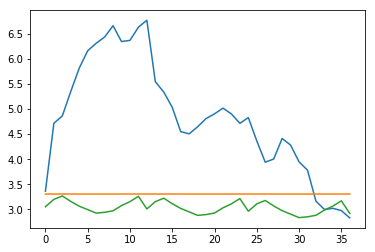

In [63]:
#plt.plot(mx['train'].iloc[0])
plt.plot(mx['test'].iloc[0])
plt.plot(mx['preds'].iloc[0][0])
plt.plot(mx['preds_models'].iloc[0].mean(axis=0))

In [18]:
ecm

[0.5919115288413667,
 0.46905565064053445,
 3.4578948624950954,
 0.7463482517320912,
 0.8847621548823131,
 0.9100642284583055,
 0.6367531162661433,
 2.1964567010605016,
 1.4150853691653154,
 0.9162465229790402,
 0.7365947669111657,
 0.5241589987091135,
 0.8851171942665403,
 0.9008368898389381,
 2.0091263292209547,
 1.1055102692467396,
 0.37145206472576675,
 0.7818856652953298,
 0.8161509473814936,
 0.5363419950748476,
 0.7035012722085505,
 1.4025058187081993,
 1.723905366733497,
 0.40459059657051116,
 2.619729015878736,
 0.6820746175354341,
 0.6254758135802336,
 0.9002418464809997,
 0.894203999986595,
 0.31224073755119497,
 0.6340190568278278,
 1.9387916079831564,
 1.1159137230394147,
 1.4990983867948695,
 1.6148858448509746,
 1.2532981631622566,
 1.2629663380887644,
 0.7840239082808396,
 1.3576492695500202,
 1.951363042128169,
 0.5294305365708828,
 2.067908181883318,
 1.8671157596062888,
 2.267328698776326,
 0.7011332383276401,
 0.48452643167978077,
 7.139503402769068,
 0.458436514258